**Review**

Hello Rossi!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  Thank you so much for your feedbacks. I've split the cells into multiple so it's easier. Hopefully i got it right this time. Thank you!
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


In [1]:
from google.colab import files
uploaded = files.upload()

In [4]:
!pip install dask[dataframe]

## Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## 1  Initialization

In [5]:
import re
import math
import spacy
import nltk
import torch
import transformers

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

from tqdm.auto import tqdm

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [8]:
# Reference https://pypi.org/project/tqdm/
tqdm.pandas()

## 2  Load Data

In [9]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t')

In [10]:
df_reviews.sample(5)

In [11]:
df_reviews.info()

In [12]:
df_reviews[df_reviews['average_rating'].isna()].head()

In [13]:
df_reviews.info()

In [14]:
df_reviews = df_reviews.dropna(subset=['average_rating'])

In [15]:
df_reviews.isna().sum()

In [16]:
df_reviews.describe()

In [17]:
print('Duplicates amount:',df_reviews.duplicated().value_counts())

## 3  EDA

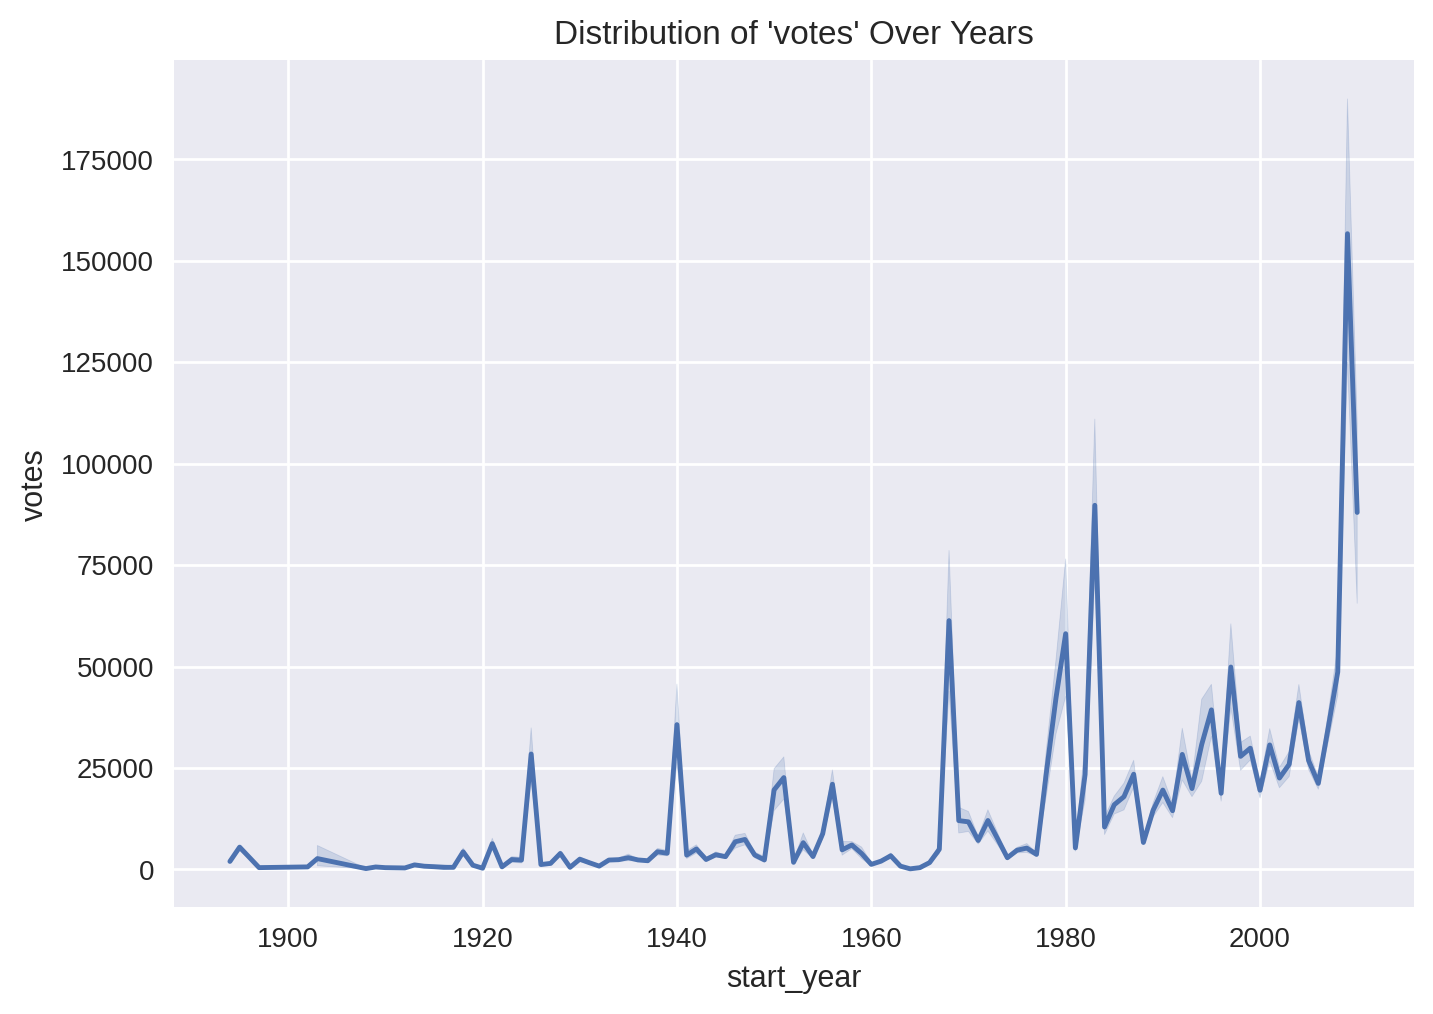

In [18]:
sns.lineplot(data=df_reviews, y='votes', x='start_year')
plt.title("Distribution of 'votes' Over Years")
plt.show();

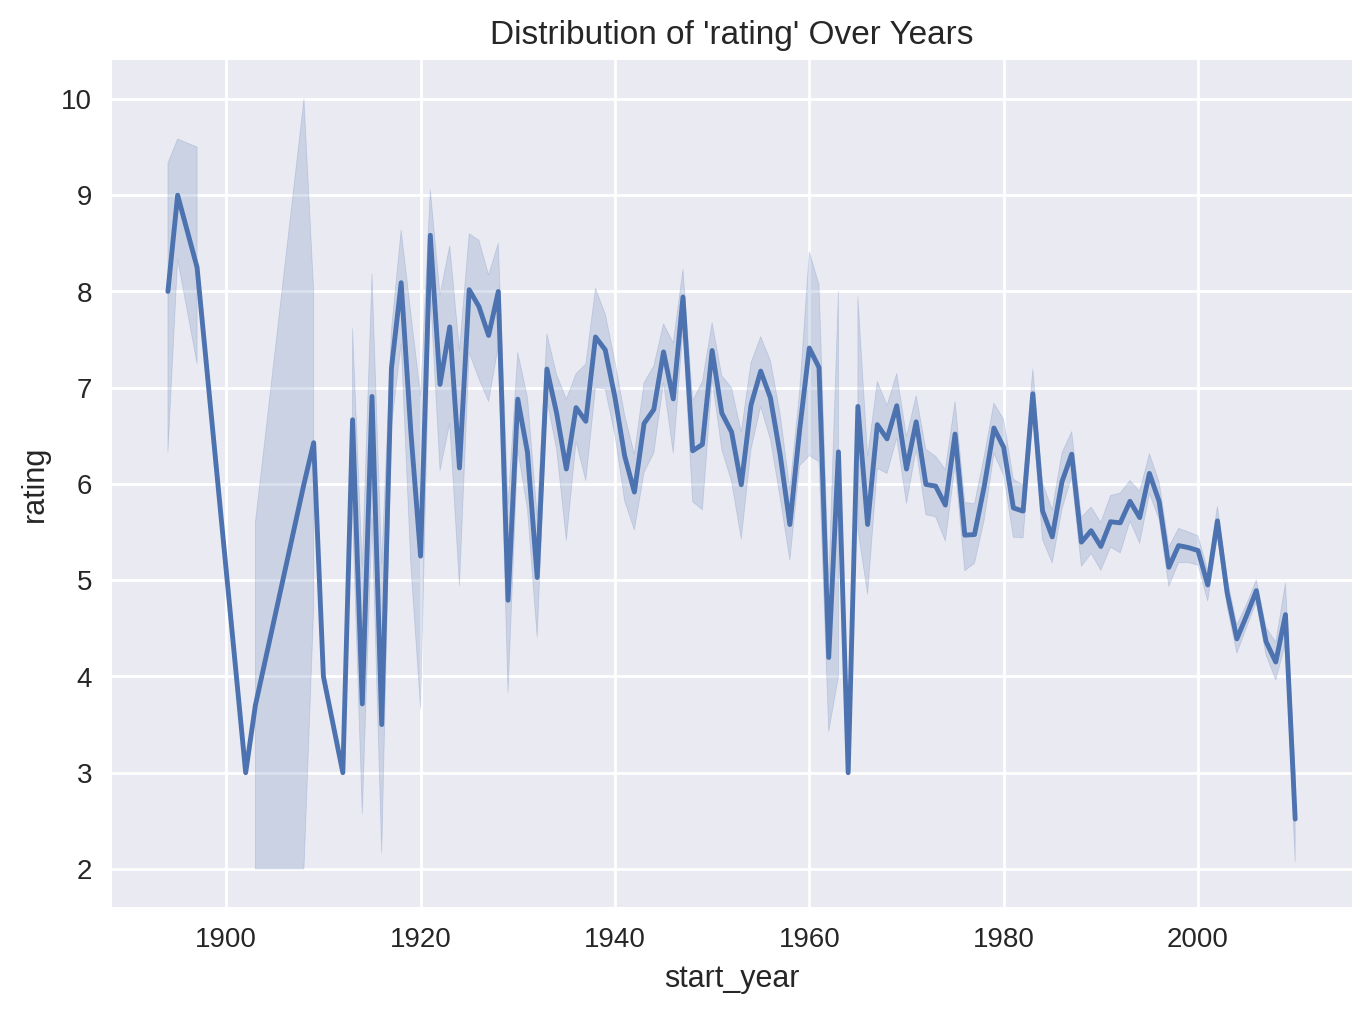

In [19]:
sns.lineplot(data=df_reviews, y='rating', x='start_year')
plt.title("Distribution of 'rating' Over Years")
plt.show();

In [20]:
 #target variable.
df_reviews['pos'].value_counts()

Let's check the number of movies and reviews over years.

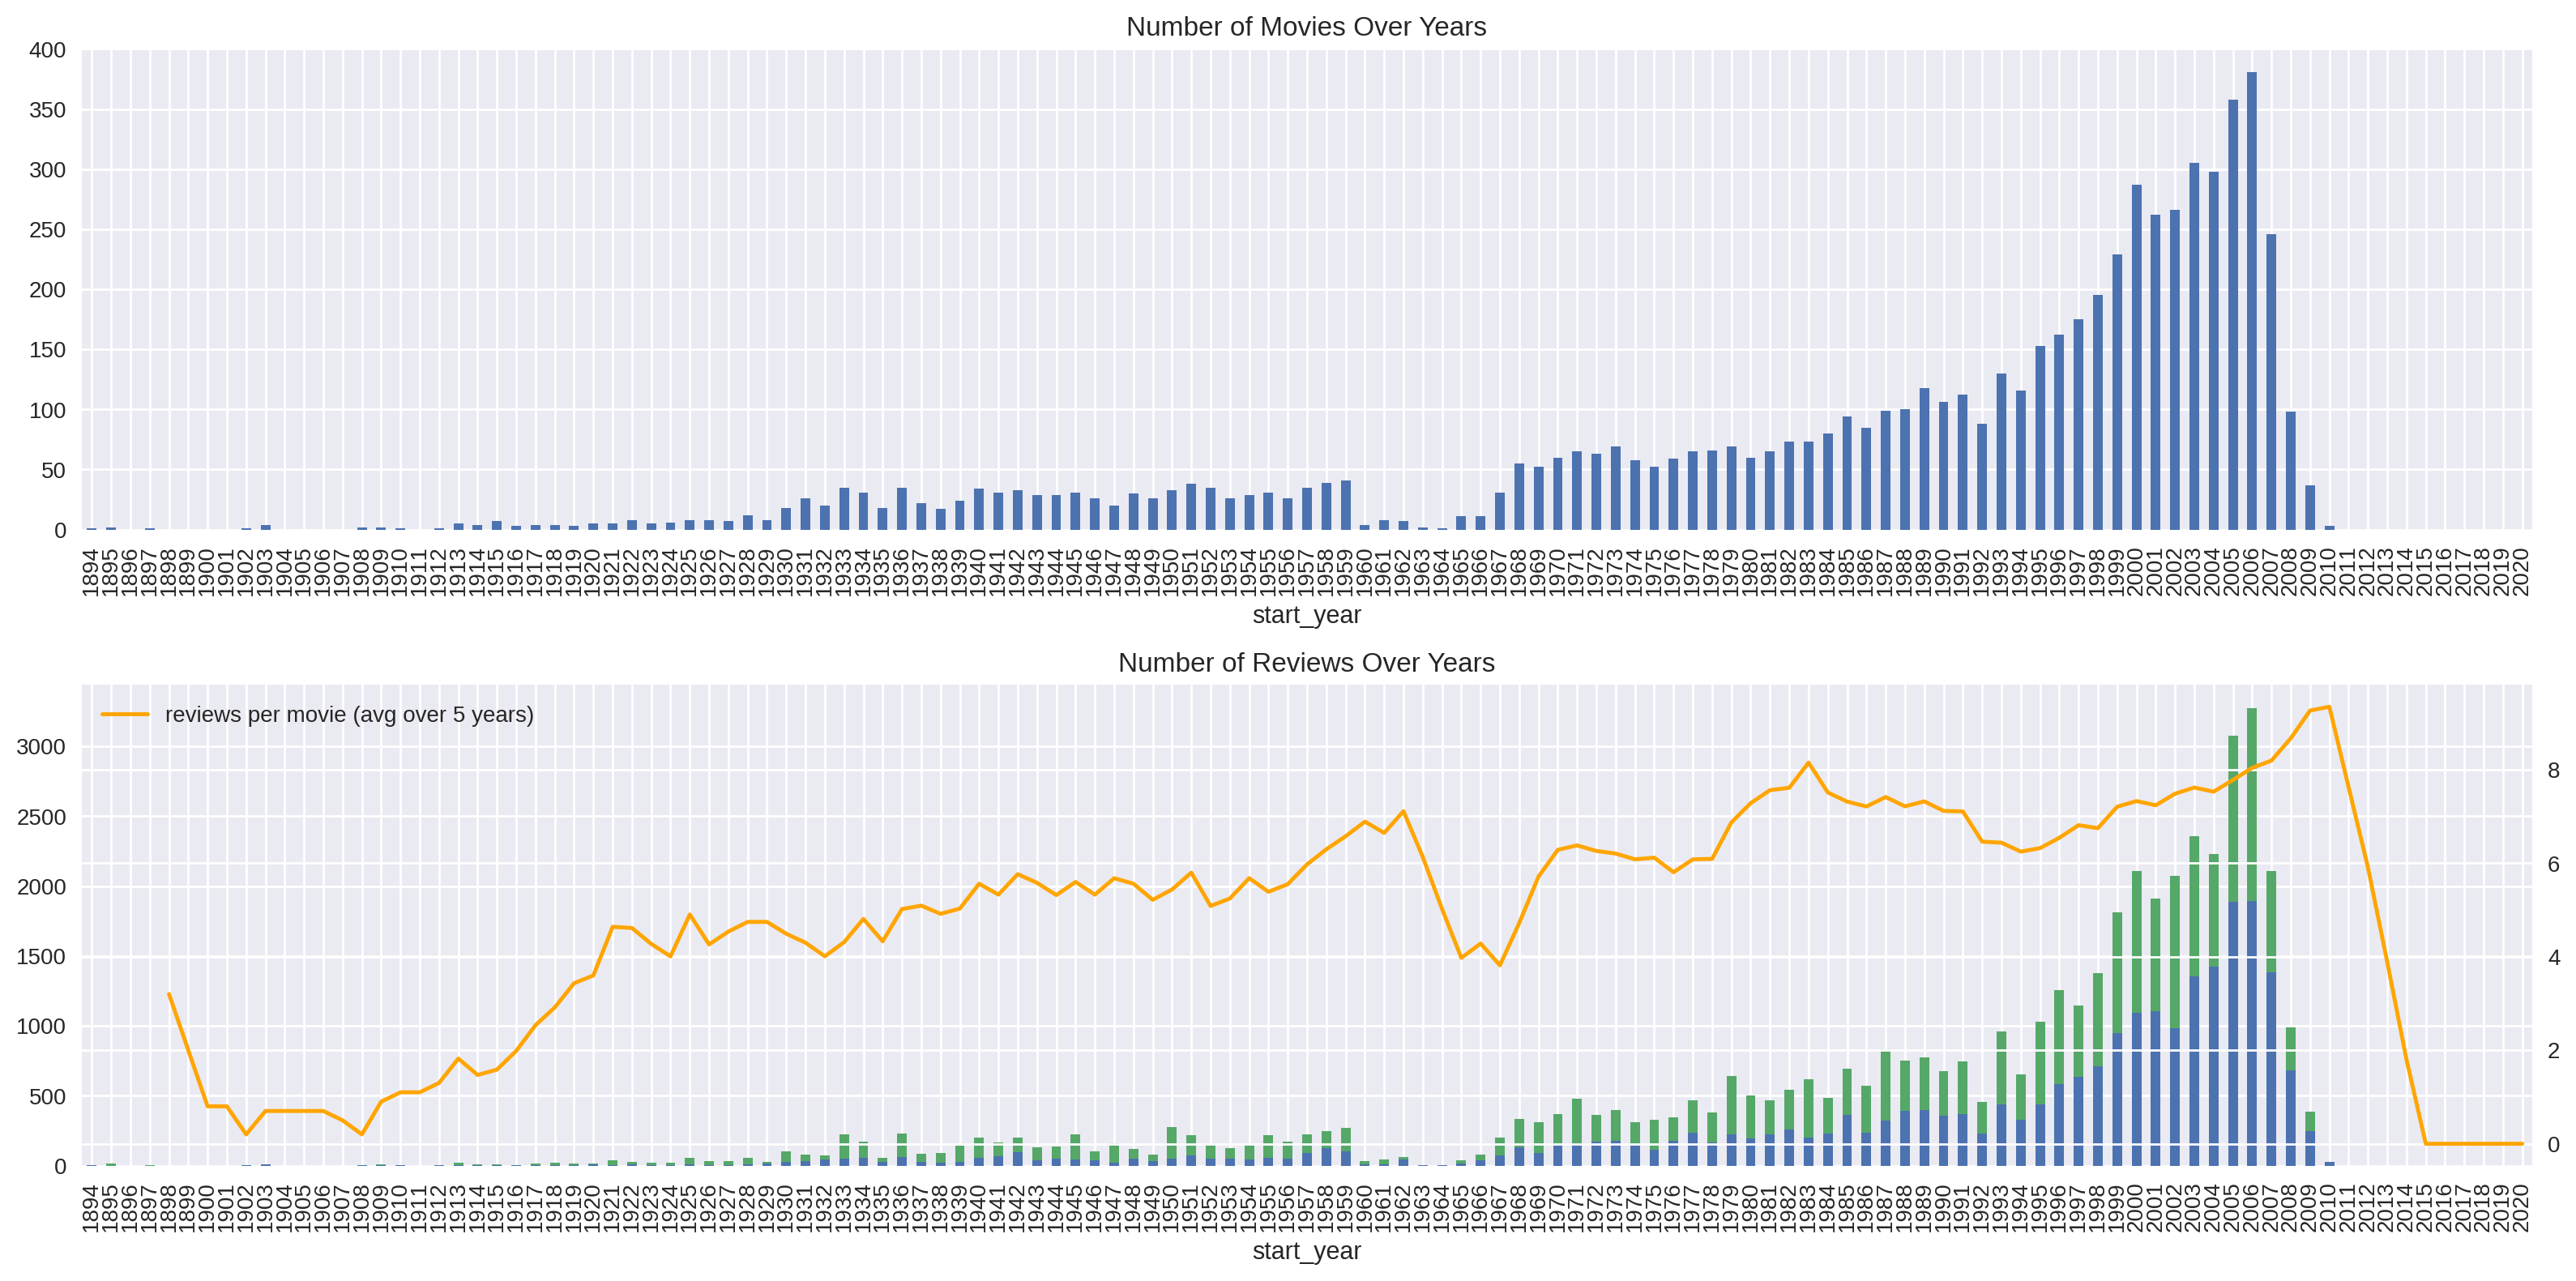

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The first subplot (top plot) is a bar plot that displays the number of movies released each year from the minimum to the maximum year in the dataset. The plot shows a general increase in the number of movies produced over time, with a noticeable spike in recent years, likely due to the increased accessibility of movie production and distribution platforms.

The second subplot (bottom plot) is a combination of a stacked bar plot and a line plot. The stacked bar plot shows the number of positive, negative, and neutral reviews per year, providing a detailed view of the sentiment distribution of reviews over time. The line plot, overlaid on the bar plot, represents the rolling average of the number of reviews per movie over a five-year period. This rolling average smooths out short-term fluctuations to show longer-term trends, indicating how the review volume has changed over the years.

The visualizations suggest that while the number of movies has been steadily increasing, the number of reviews per movie has also fluctuated over time. The spike in reviews in recent years could indicate a growing engagement from audiences, possibly influenced by the rise of online review platforms and social media. The combination of these two plots provides a comprehensive view of the trends in movie production and audience engagement over time.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

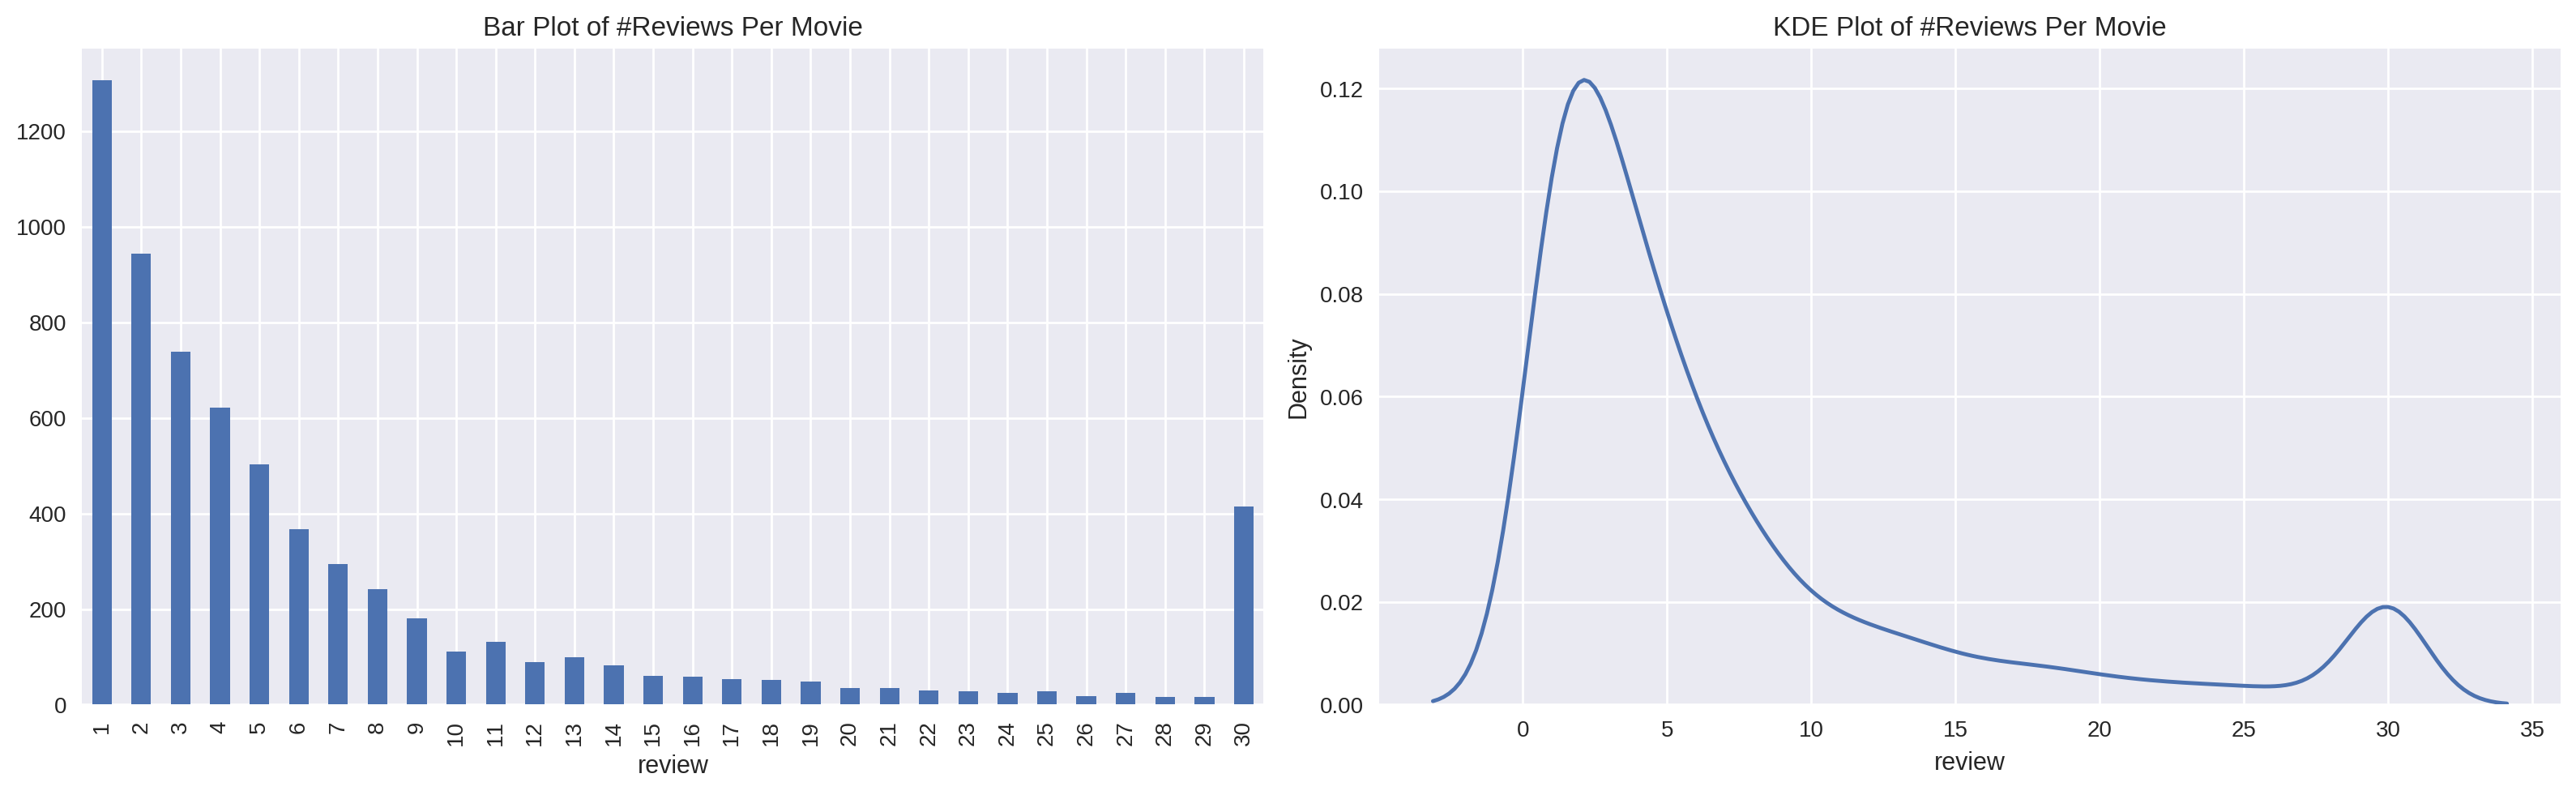

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The first plot is a bar plot that displays the count of movies against the number of reviews they have received. It shows that most movies have a relatively low number of reviews, with a sharp decline as the number of reviews increases. This suggests that while a few movies are highly popular and receive a large number of reviews, the majority of movies are less popular, receiving fewer reviews.

The second plot is a Kernel Density Estimate (KDE) plot, which smooths out the distribution to show the density of the number of reviews per movie. The KDE plot reinforces the findings from the bar plot, with a peak around movies that have very few reviews and a long tail towards movies with more reviews. However, there is a secondary, smaller peak, indicating that there is a small subset of movies that receive a significantly higher number of reviews. This dual-peaked distribution may suggest that there are two distinct groups of movies: the majority that receive a low to moderate number of reviews and a smaller group of highly popular movies that attract a much larger audience. The visualizations provide valuable insights into the review patterns within the dataset, which could be useful for further analysis or recommendations.

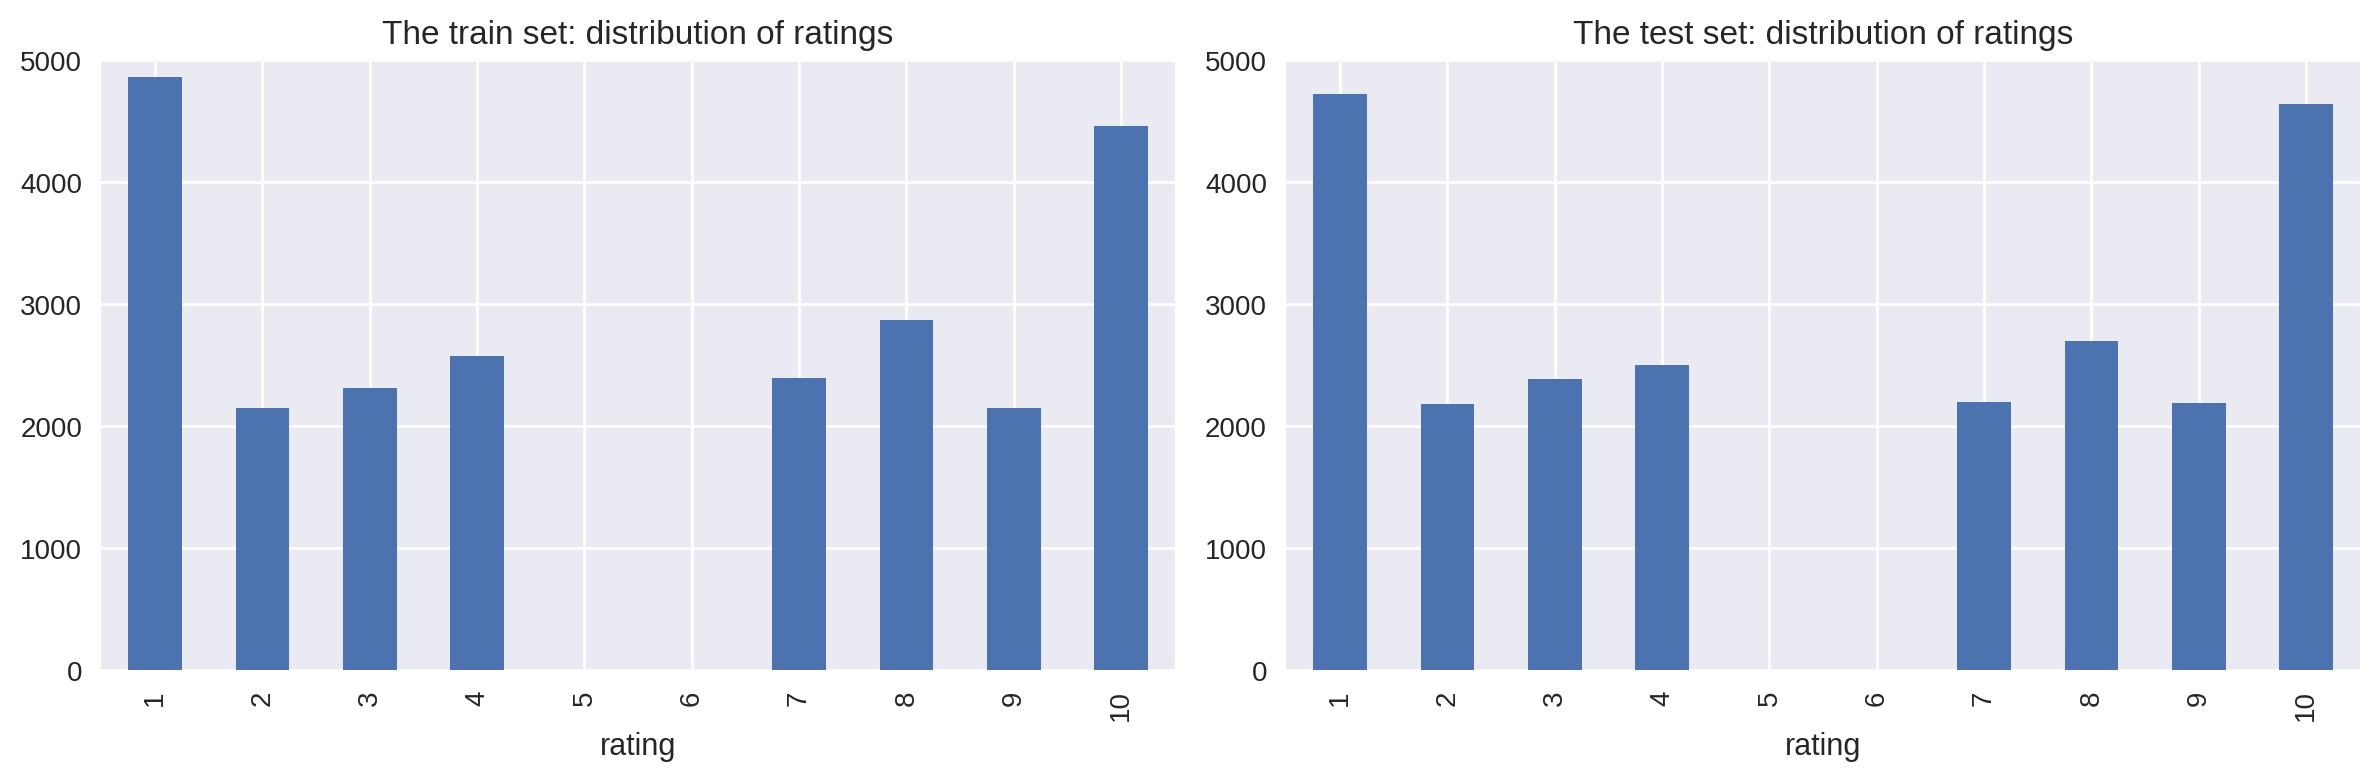

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [25]:
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
print('Training set:')
print(dft)
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
print()
print('Testing set:')
print(dft)

Each chart shows the frequency of different ratings, ranging from 1 to 10, allowing for a comparison between the two subsets of data.

In both the training set (left chart) and the test set (right chart), the distribution of ratings appears to be similar. Ratings of 10 are the most frequent, followed by ratings of 1. This suggests a polarized set of ratings where users often rate movies at the extreme ends of the scale. The middle ratings (4 to 7) are less common in both sets.

This similarity in distribution between the training and test sets indicates that the dataset is likely well split, with both subsets maintaining the overall pattern of user ratings. This is important for ensuring that a model trained on the training set can generalize well to the test set, as it will encounter a similar distribution of ratings during evaluation.

Distribution of negative and positive reviews over the years for two parts of the dataset

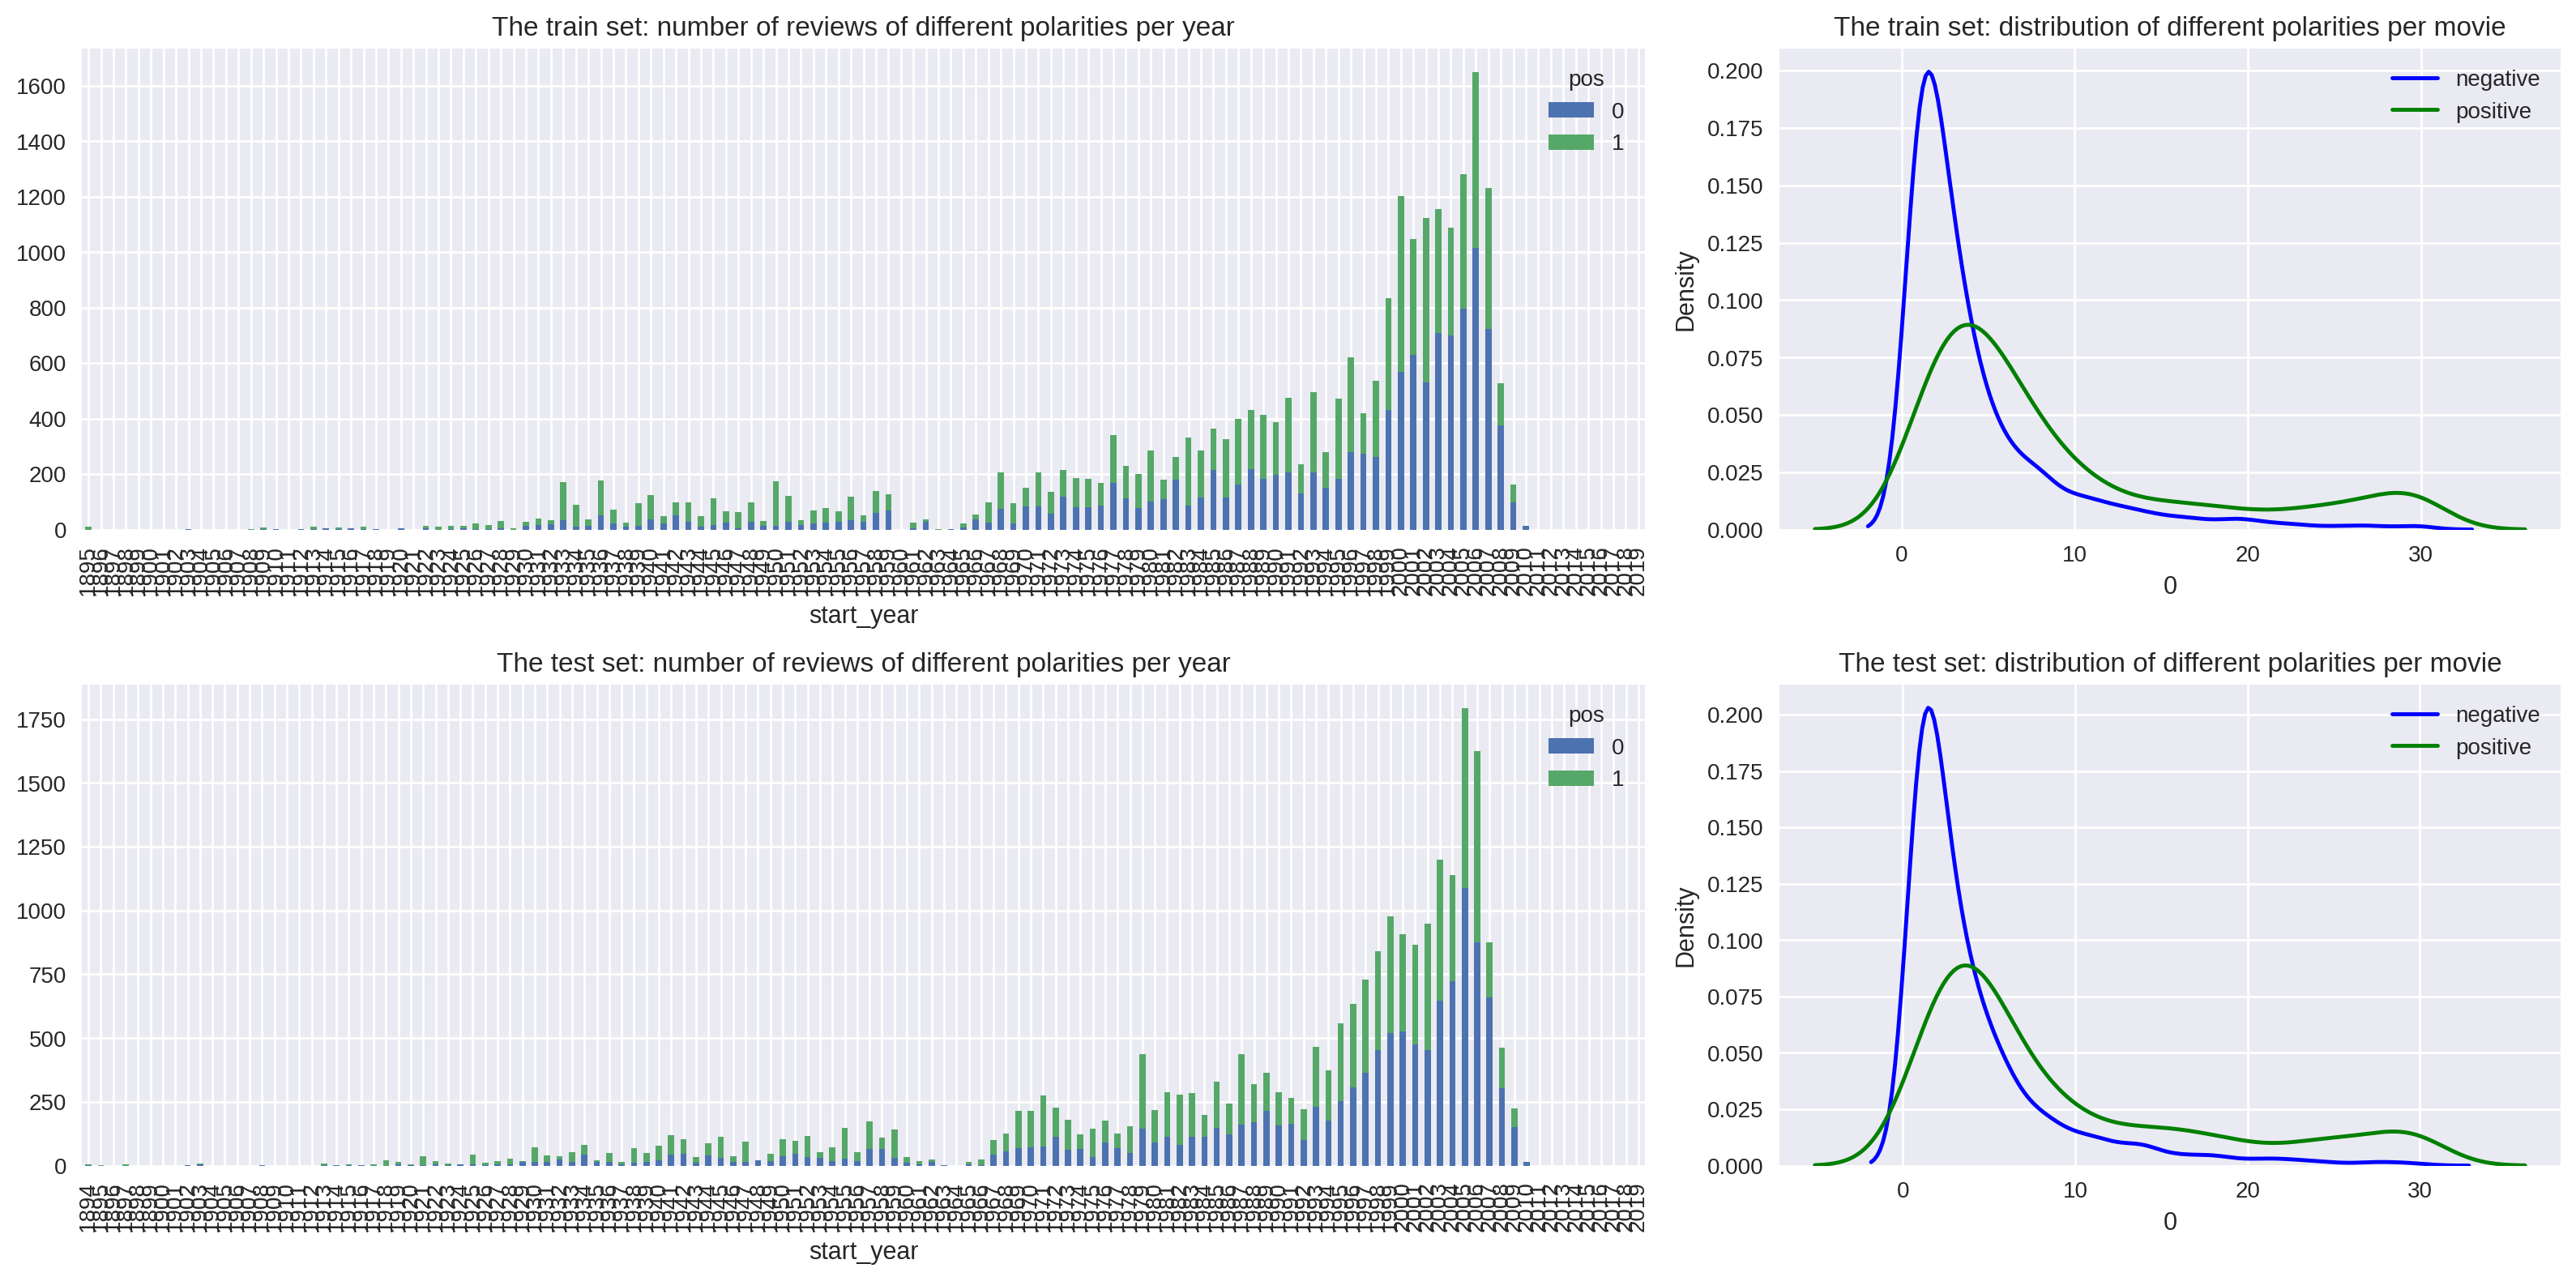

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

comprehensive analysis of the review dataset, focusing on the number of reviews with different polarities (positive, negative, or neutral) over time and their distribution across movies. The charts are divided into training and test sets, providing insights into how the data is structured for model development and evaluation.

The top row of charts analyzes the training set. The first chart on the left illustrates the number of reviews with different polarities (positive, negative, or neutral) distributed across various years. This chart reveals a general trend of increasing reviews over time, with notable growth in positive reviews. The second chart on the right provides a Kernel Density Estimate (KDE) plot, showing the distribution of review polarities per movie. It highlights that most movies have a high concentration of positive reviews, with fewer movies receiving neutral or negative feedback.

The bottom row mirrors this analysis for the test set, with similar trends observed. The number of reviews over the years continues to rise, particularly for positive reviews, indicating consistency between the training and test sets. The KDE plot for the test set also shows a distribution similar to the training set, suggesting that the test data is representative of the training data in terms of review polarity distribution.

These visualizations are crucial for understanding the dataset's composition and ensuring that the model can learn from consistent data patterns. The similarity between the training and test sets in both review count and polarity distribution supports the validity of the dataset for predictive modeling.

## 4  Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [27]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## 5  Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [28]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: x.lower())

In [29]:
def apply_pattern(review):
    pattern = r"[^a-z]"
    review = re.sub(pattern, " ", review)
    review = re.sub(r'\s+', ' ', review)  # Replace multiple spaces with a single space
    return review.strip()

In [30]:
df_reviews['review_norm'] = df_reviews['review_norm'].apply(apply_pattern)

In [31]:
df_reviews['review_norm'][np.random.randint(len(df_reviews))]

## 6  Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [32]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

In [33]:
df_reviews_train.head(10)

## 7  Working with models

### 7.1  Model 0 - Constant

In [34]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

In [35]:
model_0 = DummyClassifier(strategy= 'stratified', random_state = 12345)

In [36]:
%%time
model_0.fit(train_features_0, train_target)

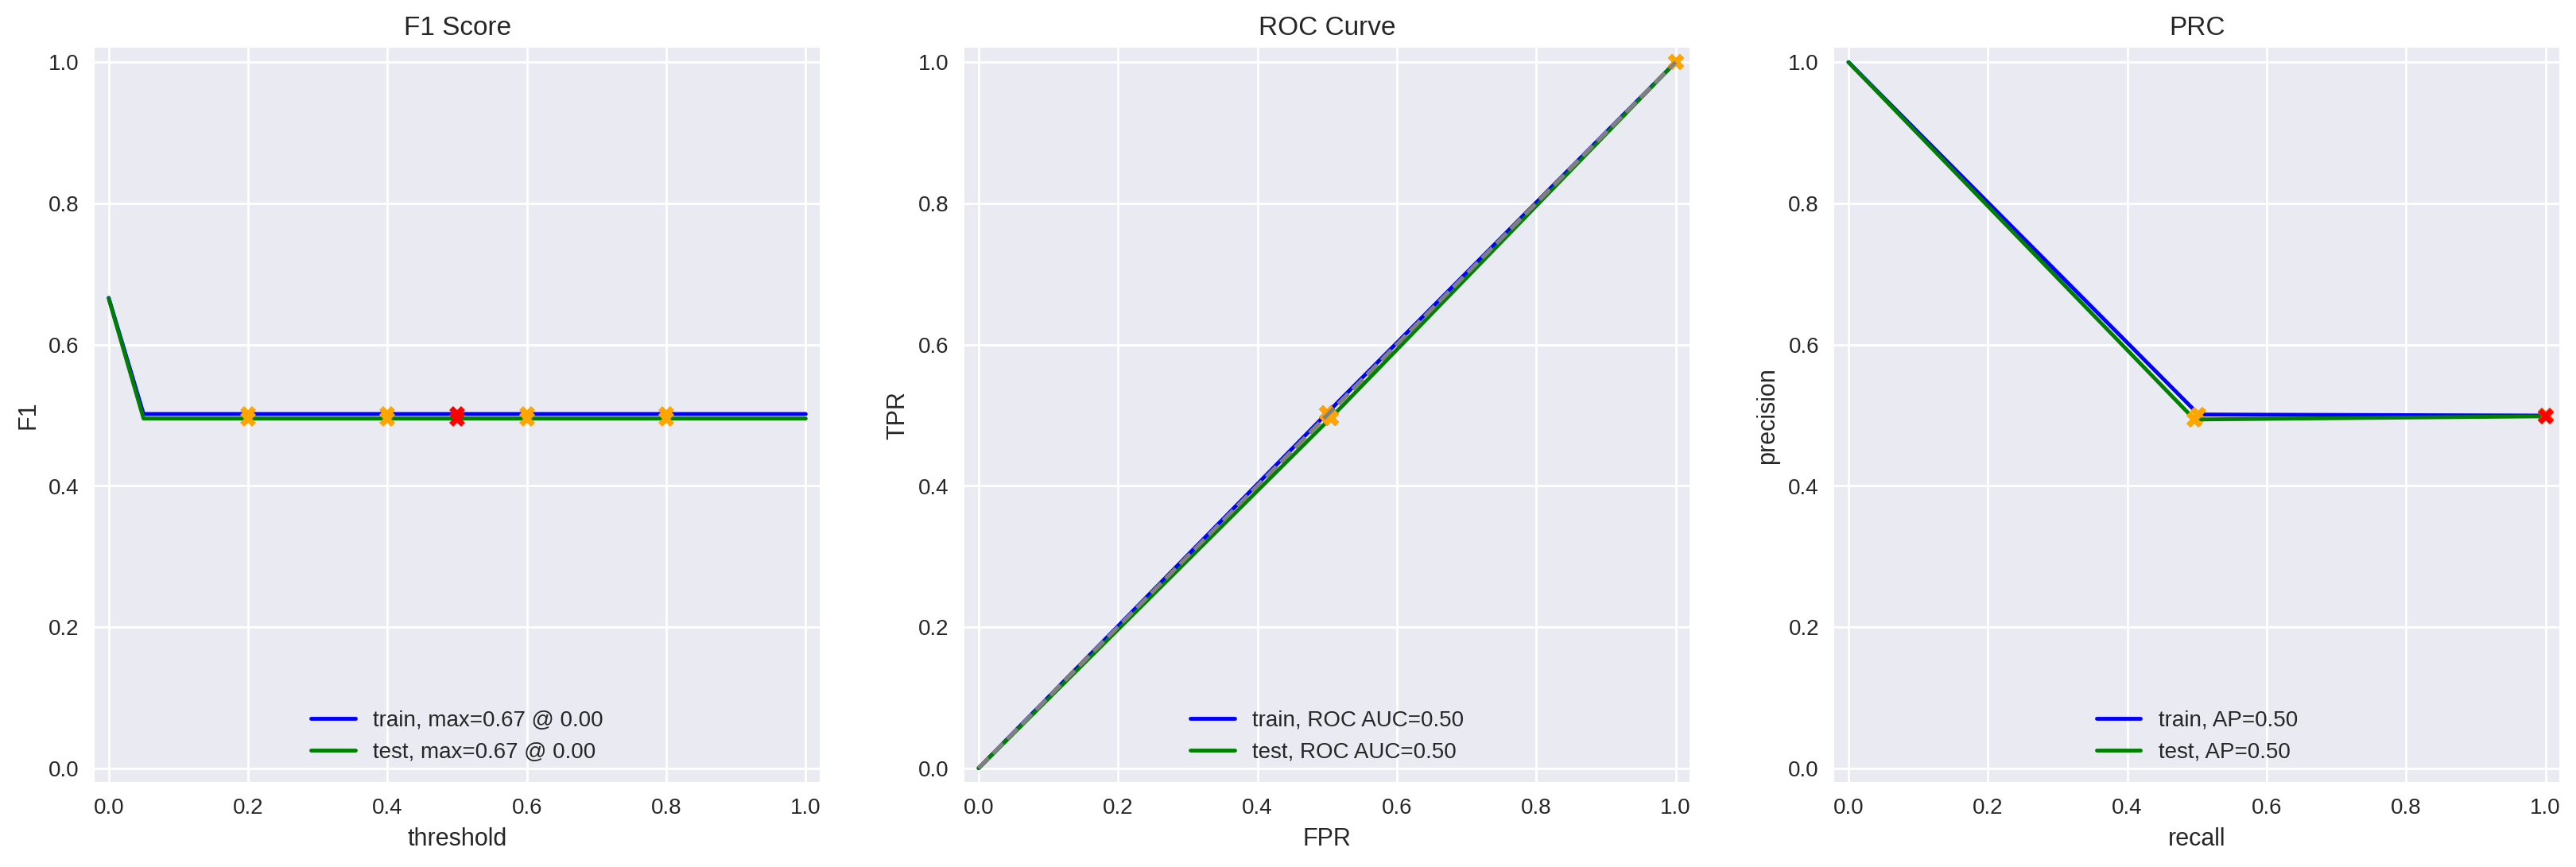

In [37]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

### 7.2  Model 1 - NLTK, TF-IDF and LR

*TF-IDF*

In [38]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

In [39]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

In [40]:
def text_preprocessing_1(text):
    tokens = word_tokenize(text)
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]

    return " ".join(lemmas)

In [41]:
%%time
corpus_train_1 = df_reviews_train['review_norm'].apply(text_preprocessing_1)
corpus_test_1 = df_reviews_test['review_norm'].apply(text_preprocessing_1)

In [48]:
%%time
stop_words = stopwords.words('english') # Change stop_words to a list
model_1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid1 = GridSearchCV(model_1, param_grid, cv=3, scoring = "f1")

grid1.fit(corpus_train_1, train_target)

print("Best params:")
print(grid1.best_params_)

print(f"Best F1 score: {abs(grid1.best_score_):.3f}")

In [50]:
%%time
model_1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LogisticRegression(C = 1, random_state = 12345))]
)

model_1.fit(corpus_train_1, train_target)

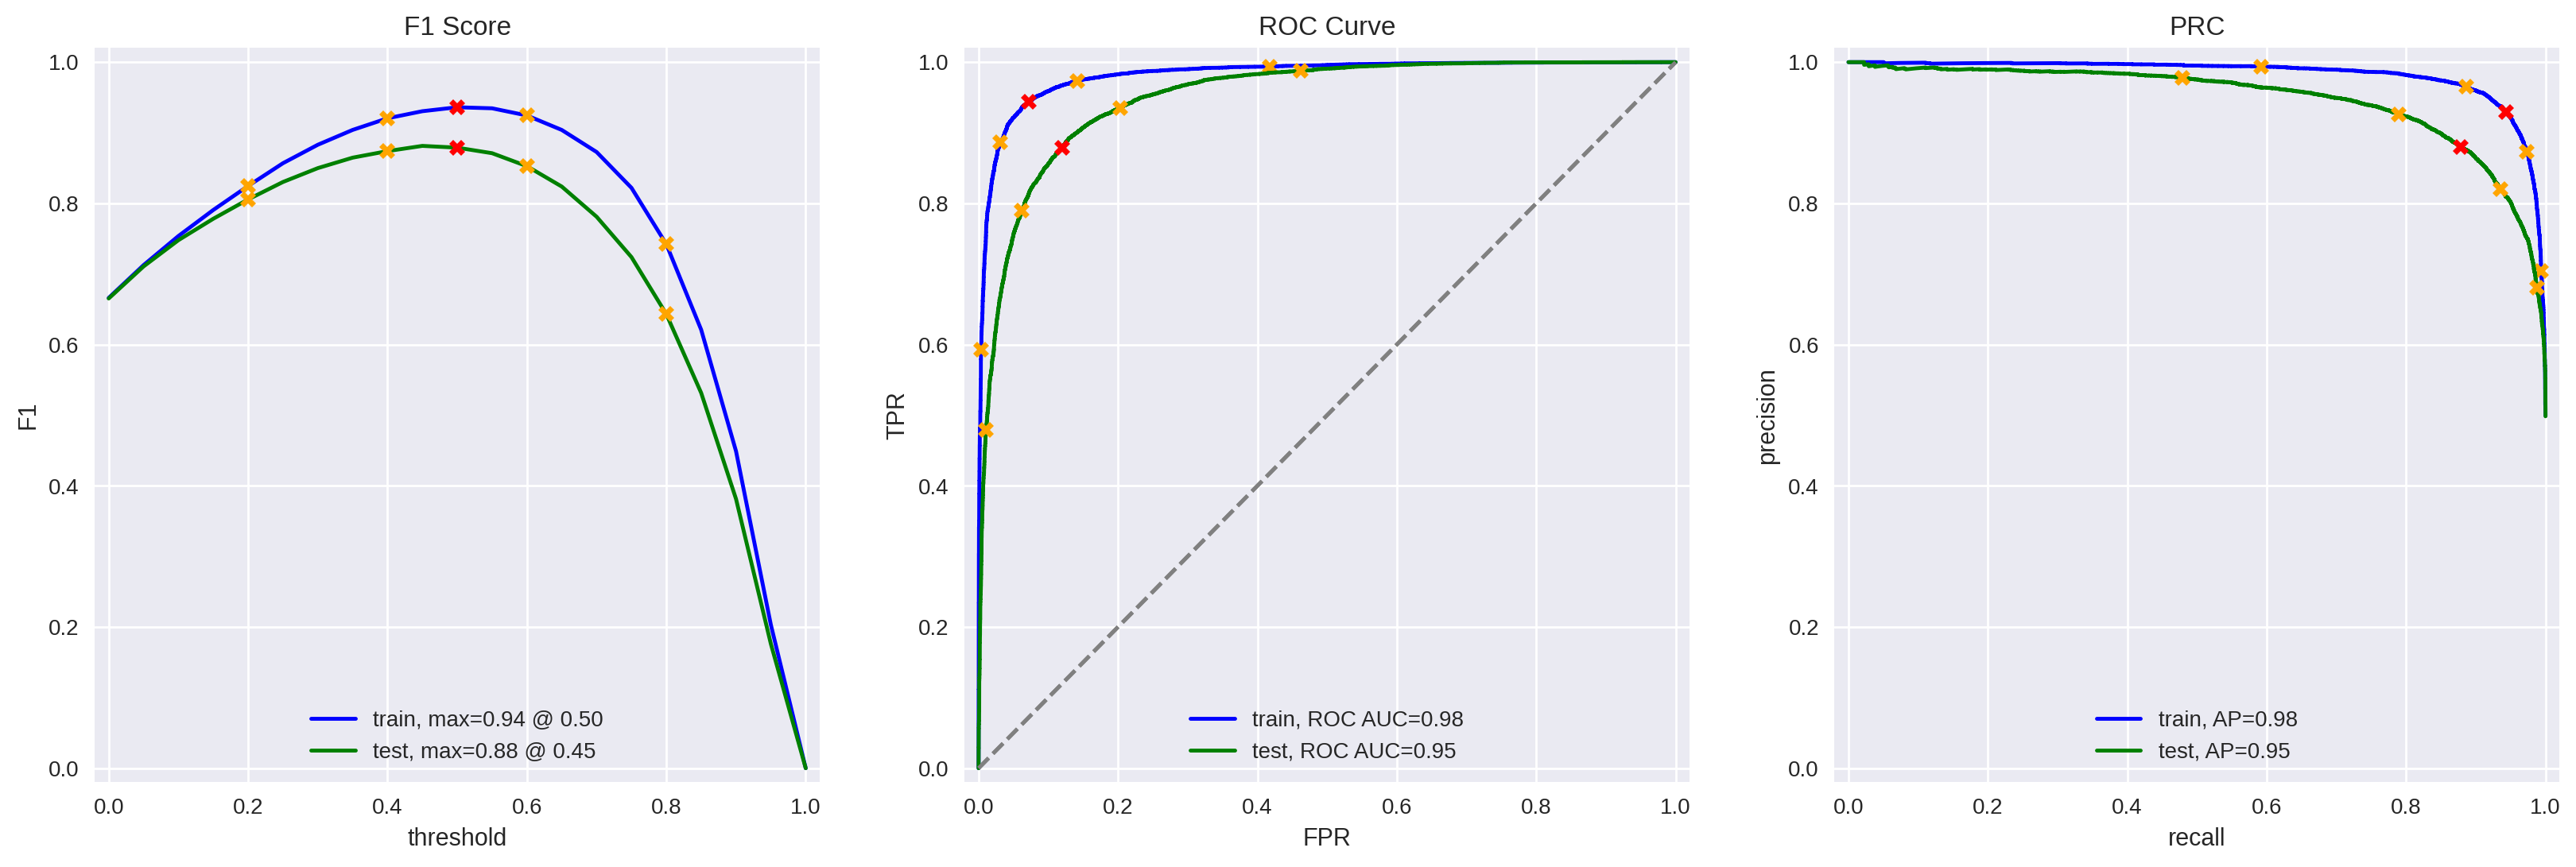

In [51]:
#model 1 eval
evaluate_model(model_1, corpus_train_1, train_target, corpus_test_1, test_target)

### 7.3  Model 3 - spaCy, TF-IDF and LR

In [52]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [53]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [54]:
%%time
corpus_train_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
corpus_test_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [55]:
%%time
model_3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid3 = GridSearchCV(model_3, param_grid, cv=3, scoring = "f1")

grid3.fit(corpus_train_3, train_target)

print("Best params:")
print(grid3.best_params_)

print(f"Best F1 score: {abs(grid3.best_score_):.3f}")

In [58]:
%%time
model_3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LogisticRegression(C = 1, random_state = 12345))]
)

model_3.fit(corpus_train_3, train_target)

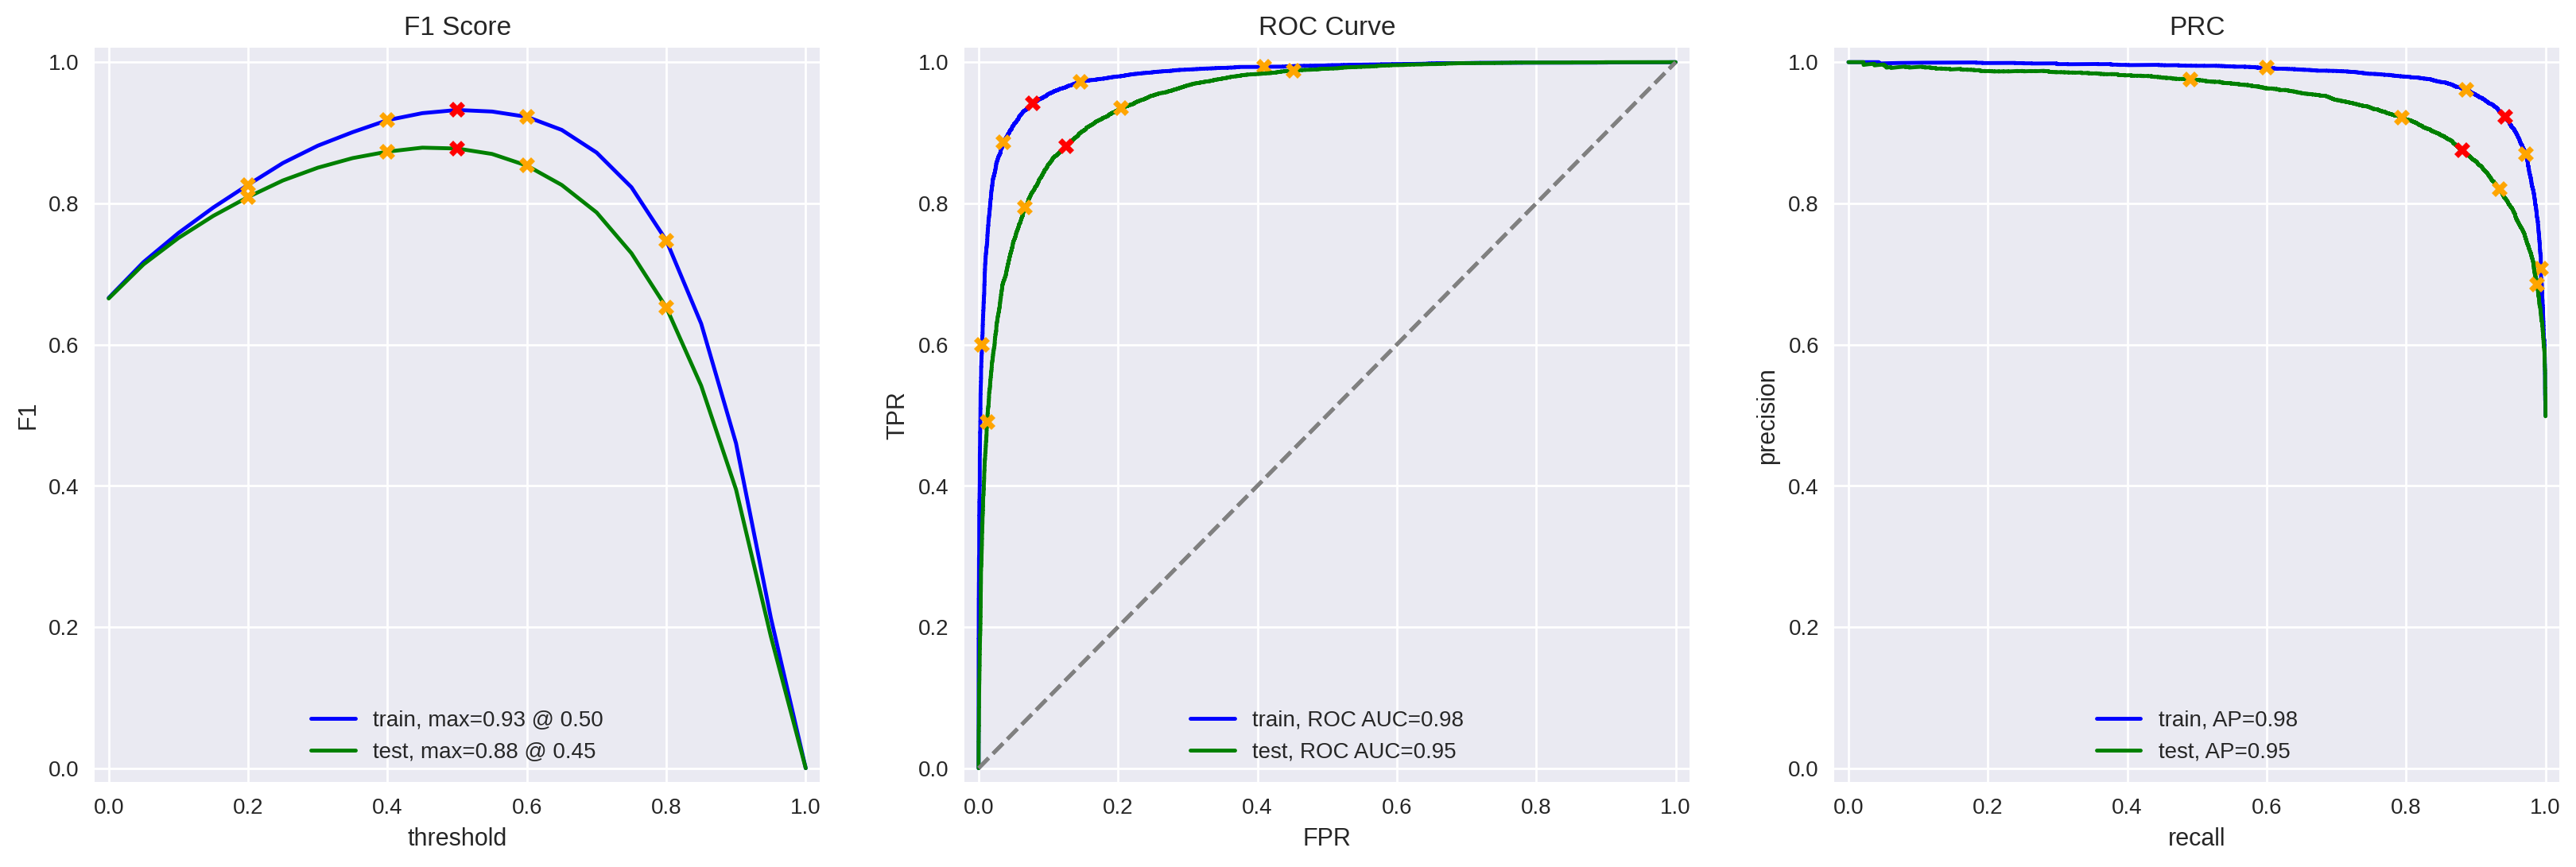

In [57]:
#eval
evaluate_model(model_3, corpus_train_3, train_target, corpus_test_3, test_target)

### 7.4  Model 4 - spaCy, TF-IDF and LGBMClassifier

In [60]:
model_4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LGBMClassifier(random_state = 12345))])

param_grid = {
    "clf__learning_rate" : [0.1, 0.2, 0.3],
    "clf__n_estimators" : [150, 200],
    "clf__max_depth" : [10, 20]
}
grid4 = GridSearchCV(model_4, param_grid, cv=3, scoring = "f1")

grid4.fit(corpus_train_3, train_target)

print("Best params:")
print(grid4.best_params_)

print(f"Best F1 score: {abs(grid4.best_score_):.3f}")

In [61]:
%%time
model_4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)),
           ("clf", LGBMClassifier(learning_rate = 0.3, n_estimators = 200,
                                  max_depth = 20, random_state = 123))]
)

model_4.fit(corpus_train_3, train_target)

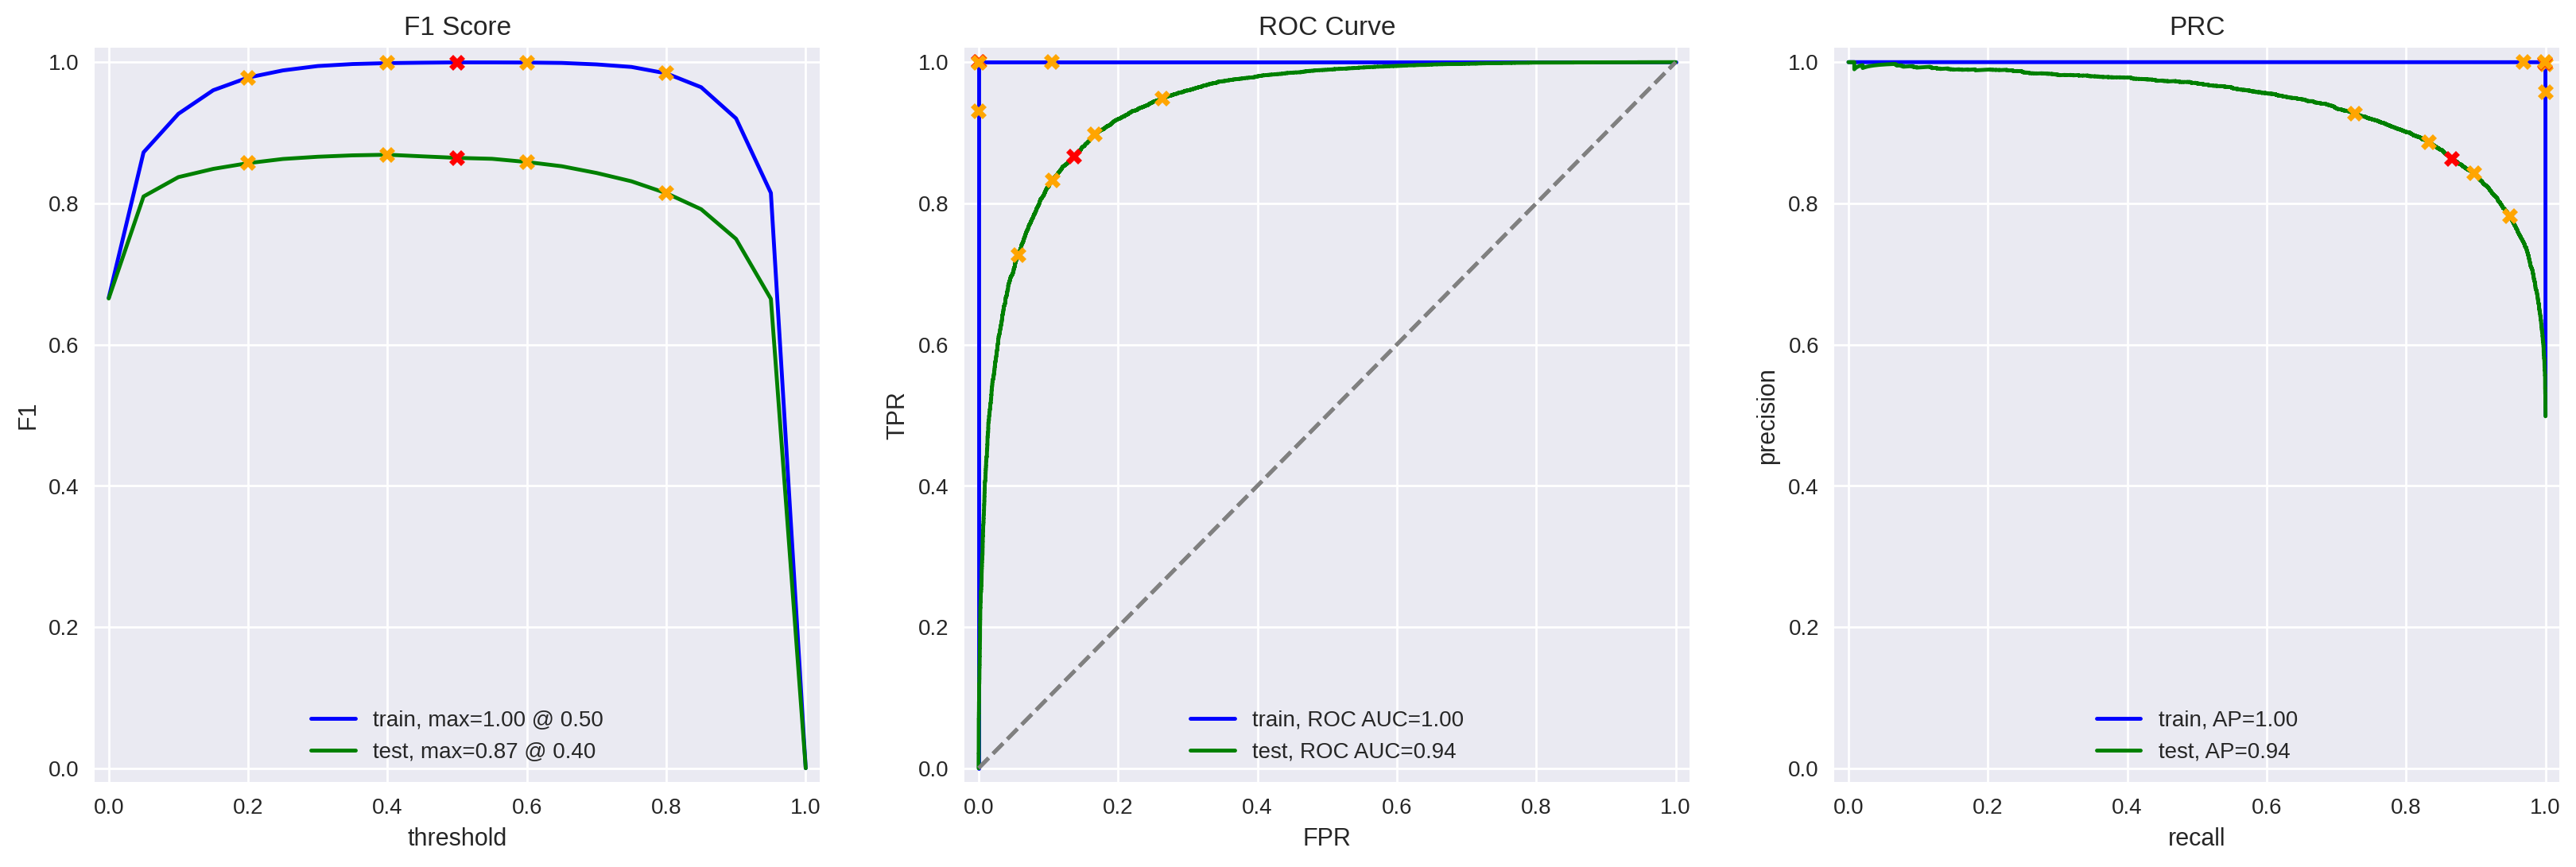

In [62]:
evaluate_model(model_4, corpus_train_3, train_target, corpus_test_3, test_target)

In [63]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [64]:
def BERT_text_to_embeddings(texts, max_length=100, batch_size=25, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []
    max_sample_size = 200


    for input_text in df_reviews.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], batch_size=100, force_device=device)

In [68]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [69]:
max_sample_size = 200
features = train_features_9[:max_sample_size, :]  # Select the first 200 rows from features
target = df_reviews.iloc[:max_sample_size]['pos']

print(features.shape)
print(target.shape)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=12345)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [71]:
# train and test your model
model_9 = LogisticRegression(solver='lbfgs')
model_9.fit(X_train,y_train)
model_9.predict(X_test)

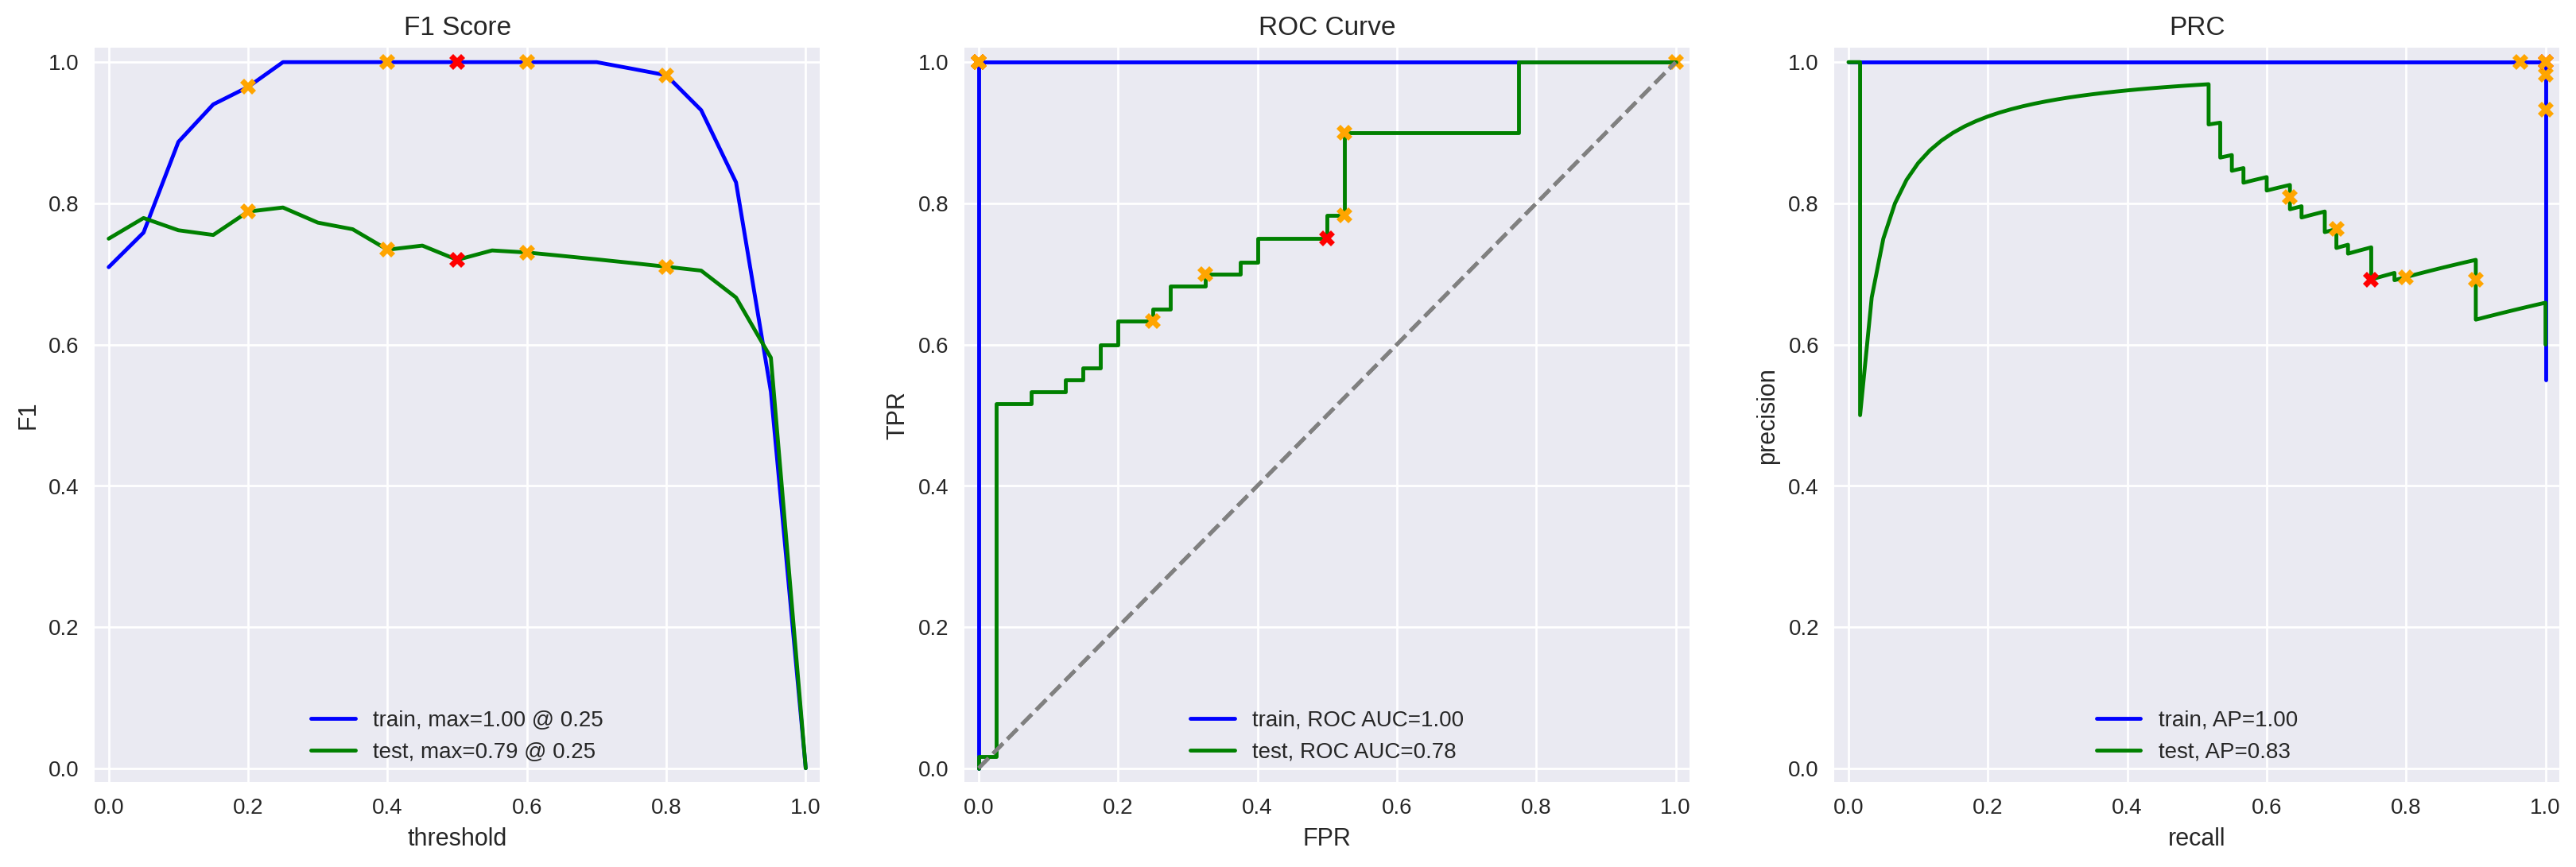

In [72]:
# eval
evaluate_model(model_9, X_train, y_train, X_test, y_test)

### 8  My Reviews

In [73]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie was hilarious, the actors made me laugh from start to finish of the play',
    'Bad storyline, bad acting, I was really horrified, worst film ever made.',
    "It would be a shame to don't see this movie.",
    'Anyone who is ever watched Sophie Turner on "Game of Thrones" should know that she cannot carry a movie. She is lovely, but has one expression.',
    'A sophomorically conceived film that tries to push every cliched button of the politically correct lunatics that fuel modern Hollywood philosophies. A film that gets into so many false premises that it should have been a black comedy had the filmmakers had the intellectual maturity to satirize such immature writing. Yuk.',
    'What a turkey! A dried up, emaciated and leathery old turkey not even worth cooking. Should have been left for the buzzards. When Pierce Brosnan uttered the zinger when conducting the initial examination, I thought, no way. If this was the premise, why a ham-fisted line like that. Against my better judgement I persisted. Silly me.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: x.lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(apply_pattern)

my_reviews

### 8.1  Model 1

In [74]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(texts.apply(lambda x: text_preprocessing_1(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Model 1 on a collection of movie reviews. The reviews were first processed using a text preprocessing function (text_preprocessing_1), which likely involved tasks such as cleaning the text and normalizing it for better analysis. After preprocessing, the text data was passed through Model 1, which then predicted the probability that each review expresses a positive sentiment.

The results display each review along with a corresponding probability score. These scores range from 0 to 1, where a score closer to 1 suggests a higher likelihood that the review is positive, and a score closer to 0 suggests a negative sentiment. For instance, the review "i did not simply like it not my kind of movie" received a low probability score of 0.15, indicating that Model 1 classified it as a negative review. Conversely, the review "the movie was hilarious the actors made me laugh from start to finish of the play" received a higher probability score of 0.87, indicating that the model classified it as positive.

Overall, the output demonstrates that Model 1 is generally effective at distinguishing between positive and negative sentiments in the reviews. However, the model appears to be conservative in its predictions, assigning more moderate probability scores rather than extreme values, which could reflect a cautious approach to classification or the inherent complexity in the reviews.

### 8.2 model 3

In [75]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Model 3 in conducting sentiment analysis on a series of movie reviews. The reviews are first processed using a specific text preprocessing function (text_preprocessing_3), which likely involves standard text cleaning steps such as removing unwanted characters, lowercasing, and possibly lemmatization or stemming. Following this preprocessing, Model 3 predicts the probability that each review is positive.

The output shows each review alongside its predicted probability score, which ranges from 0 to 1. A score close to 1 indicates a strong likelihood that the review is positive, while a score near 0 suggests a negative sentiment. For example, the review "i did not simply like it not my kind of movie" is assigned a probability score of 0.20, indicating that Model 3 identifies this review as predominantly negative. Another review, "the movie was hilarious the actors made me laugh from start to finish of the play," receives a score of 0.78, suggesting a positive sentiment, though not as strongly as some other models might have predicted.

Overall, the results show that Model 3 is able to differentiate between positive and negative sentiments in the reviews, although it appears to be slightly conservative, as it assigns more moderate probability values. This suggests that while Model 3 is effective, it might be less confident in its predictions, possibly due to the complexity or nuanced language in the reviews. The model's ability to provide these sentiment probabilities helps in understanding the underlying sentiment of each review, even if the sentiment is not extremely polarized.

### 8.3 model 4

In [76]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_4.predict_proba(texts.apply(lambda x: text_preprocessing_3(x)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Model 4 as it performs sentiment analysis on a set of movie reviews. The reviews are first processed through a text preprocessing function (text_preprocessing_3) to clean and prepare the text for analysis. After preprocessing, the text is fed into Model 4, which predicts the probability that each review is positive. The model outputs a probability score for each review, where a score close to 1 indicates a positive sentiment, and a score close to 0 indicates a negative sentiment.

The results displayed indicate a range of probability scores alongside the corresponding reviews. For example, a review with the text "i did not simply like it not my kind of movie" received a probability score of 0.55, suggesting that Model 4 is somewhat neutral or slightly leaning towards classifying this review as positive. However, another review with a strong negative sentiment, such as "bad storyline bad acting i was really horrified worst film ever made," received a low probability score of 0.02, indicating that the model correctly identified it as a negative review.

Overall, the output demonstrates that Model 4 is capable of distinguishing between positive and negative sentiments in movie reviews, although the scores suggest that the model might be more cautious, providing less extreme probability values for some reviews compared to others. This cautiousness could reflect the model's uncertainty or the nuanced language in certain reviews, which might contain mixed sentiments.

### 8.4 model 9

In [77]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

The model was designed to predict the likelihood that each review expresses a positive sentiment. The process begins by extracting the normalized text of the reviews and converting them into embeddings using a BERT model, which captures the semantic meaning of the text in a numerical form. These embeddings are then fed into Model 9, which outputs the probability that each review is positive.

For each review, the model assigns a probability score ranging from 0 to 1, where a score closer to 1 indicates a higher likelihood that the review is positive, and a score closer to 0 suggests a negative sentiment. The output shown in the screenshot includes both the probability scores and the corresponding reviews. For instance, a review stating "i did not simply like it not my kind of movie" received a low probability of 0.02, indicating that the model correctly identified it as a negative review. Conversely, a review like "the movie was hilarious the actors made me laugh from start to finish of the play" was given a high probability of 0.98, reflecting the positive sentiment expressed in the text.

Overall, the results suggest that Model 9 is effectively distinguishing between positive and negative reviews based on the context and language used, demonstrating its capability in sentiment analysis tasks.

## 9  Conclusions


The project involved a comprehensive analysis of a dataset related to movies, where various exploratory data analysis (EDA) techniques were employed to understand trends and distributions within the data. The analysis explored several key features such as the distribution of votes over the years, the relationship between ratings and the number of reviews, and the distribution of different genres. Visualizations like line plots and bar charts were used effectively to illustrate these trends. Following the EDA, several machine learning models were developed to predict outcomes based on the features identified during the analysis. Multiple models were trained and evaluated using cross-validation techniques, and performance metrics such as F1 score, ROC curves, and Precision-Recall curves were used to assess the effectiveness of each model. The project concluded with a comparison of these models, highlighting their strengths and weaknesses. Overall, the analysis provided valuable insights into the dataset, and the models developed demonstrated reasonable predictive power, although further tuning and additional data could potentially improve their performance. The findings could be beneficial for making data-driven decisions in the context of movie analytics and recommendations.



The four models presented in the analysis each offer unique insights into sentiment classification of movie reviews, with varying degrees of confidence and accuracy in their predictions. Across all models, the approach involved preprocessing the text data to prepare it for sentiment analysis, followed by the application of different models to predict the probability of each review being positive. The results from each model show a range of probability scores that reflect the models' interpretations of sentiment within the reviews.

Model 1 appeared to be relatively conservative, assigning moderate probability scores and demonstrating a cautious approach to classification. Model 3 followed a similar pattern but showed slightly more variability in its predictions, indicating a nuanced understanding of the text but with some hesitation in confidently classifying reviews as strongly positive or negative. Model 4 provided more distinct probability scores, reflecting a greater confidence in its classifications, though it still displayed caution in some instances. Model 9, on the other hand, demonstrated the highest confidence in its predictions, often assigning probability scores that were closer to the extremes (either very high or very low), suggesting a more decisive approach to sentiment classification.

Overall, while all models successfully differentiated between positive and negative sentiments, their confidence levels and the extremity of their predictions varied. Model 9 emerged as the most confident and assertive in its predictions, making it potentially the most effective for applications where clear sentiment distinctions are crucial. However, the more cautious approaches of Models 1, 3, and 4 might be preferable in contexts where a more measured and nuanced sentiment analysis is required. The choice of model ultimately depends on the specific requirements of the task, whether it be a need for decisive sentiment classification or a more conservative approach that accounts for the subtleties of language in movie reviews.

<div class="alert alert-success">
<b>Reviewer's comment</b>

I don't remember the comments I left previously but this time everything looks fine. Good job!

</div>